# Installing dependencies

In [ ]:
!pip install geopandas
!pip install sentinelhub
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Specifying file tree

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

dataset_name = 'dlr_fusion_competition_germany'
sentinel2_name = f'{dataset_name}_train_source_sentinel_2'
labels_name = f'{dataset_name}_train_labels'
download_path = os.path.join('.', 'germany_sentinel2_data')

data_coords = '33N_18E_242N'
geojson_dir = os.path.join(download_path, labels_name, f'{labels_name}_{data_coords}')
bands_dir = os.path.join(download_path, sentinel2_name, f'{sentinel2_name}_{data_coords}_2018')

# Pulling data from hub

In [ ]:
!pip install radiant_mlhub
!mlhub configure

In [ ]:
from radiant_mlhub import Collection, Dataset

ds = Dataset.fetch(dataset_name)
for collection in ds.collections:
    if collection.id in [labels_name, sentinel2_name]:
      archive_path = collection.download(download_path)

In [ ]:
import tarfile
from glob import glob

for gz in glob(os.path.join(download_path, "*.gz")):
    #unpacking
    print(f"unzipping {gz} to {download_path}")
    tar = tarfile.open(gz, "r:gz")
    tar.extractall(download_path)
    tar.close()
    #cleaning up
    os.remove(gz)

# Defining Keras Data Sequence

In [ ]:
from tensorflow import keras
import math
from random import shuffle, seed
import pickle
import sentinelhub
import geopandas as gpd
import numpy as np
import rasterio as rio
from rasterio import features

CLASSES = ["Wheat", "Rye", "Barley", "Oats", "Corn", "Oil Seeds", "Root Crops", "Meadows", "Forage Crops", "Canola", "Lucerne", "Small grain grazing"]
CROP_IDS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
min_area=1000
geojson_filename = 'labels.geojson'
labelgeojson=os.path.join(geojson_dir, geojson_filename)


with open(os.path.join(bands_dir, "bbox.pkl"), 'rb') as f:
    bbox = pickle.load(f)
    crs = str(bbox.crs)
    minx, miny, maxx, maxy = bbox.min_x, bbox.min_y, bbox.max_x, bbox.max_y

labels = gpd.read_file(labelgeojson)
labels = labels.to_crs(crs)

mask = labels.geometry.area > min_area
print(f"ignoring {(~mask).sum()}/{len(mask)} fields with area < {min_area}m2")
labels = labels.loc[mask]

bands = np.load(os.path.join(bands_dir, "bands.npy"), mmap_mode='r')
#print(bands[...,0].max())

clp = np.load(os.path.join(bands_dir, "clp.npy"), mmap_mode='r')

temporal_length, width, height, bands_count = bands.shape

transform = rio.transform.from_bounds(minx, miny, maxx, maxy, width, height)

crop_mask = features.rasterize(
    zip(labels.geometry, labels.crop_id), all_touched=True,
    transform=transform, out_shape=(width, height)
).astype('uint8')

assert len(np.unique(crop_mask)) > 0, f"vectorized fid mask contains no fields. " \
    f"Does the label geojson {geojson_filename} cover the region defined by {bands_dir}?"

ignoring 30/2534 fields with area < 1000m2


In [ ]:
class Sentinel2Data(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, img_size, batch_size, bands, mask, indexes):
        self.image_size = img_size
        self.batch_size = batch_size
        self.bands = bands
        self.mask = crop_mask
        self.indexes = indexes
    def on_epoch_end(self):
        shuffle(self.indexes)

    def __len__(self):
        return len(self.indexes) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        idx_start = idx * self.batch_size
        idx_end = idx_start + self.batch_size
        if idx_end > len(self)*self.batch_size:
          idx_end = len(self)*self.batch_size
          idx_start = idx_end-self.batch_size

        batch_idxs = self.indexes[idx_start:idx_end]

        x = np.zeros(shape=(len(batch_idxs), self.image_size[0], self.image_size[1], 3), dtype='float32')
        y = np.zeros(shape=(len(batch_idxs), self.image_size[0], self.image_size[1]), dtype='uint8')

        for i in range(len(batch_idxs)):
            temporal_i, row_bounds, col_bounds = batch_idxs[i]
            x[i] = self.bands[temporal_i, row_bounds[0]:row_bounds[1], col_bounds[0] : col_bounds[1], :] / 21412.0
            y[i] = self.mask[row_bounds[0]:row_bounds[1], col_bounds[0] : col_bounds[1]]

        return x, y

In [ ]:
sample_shape=(256,256)

samples_in_row = math.ceil(width / sample_shape[0])
samples_in_col = math.ceil(height / sample_shape[1])

indexes = []
for temporal_index in range(temporal_length):
    for y_i in range(samples_in_col):
        col_start = y_i * sample_shape[1]
        col_end = col_start + sample_shape[1]

        if col_end > height:
            col_start = width - sample_shape[1]
            col_end = height

        for x_i in range(samples_in_row):
            row_start = x_i * sample_shape[0]
            row_end = row_start + sample_shape[0]

            if row_end > width:
                row_start = width - sample_shape[0]
                row_end = width

            mean_clp = np.mean(clp[temporal_index, row_start:row_end, col_start : col_end, 0] / 255.)
            if mean_clp < 0.4:
                indexes.append((temporal_index, (row_start, row_end), (col_start, col_end)))

seed(2023)
shuffle(indexes)

In [ ]:
validation_split=0.7
split_index = math.ceil(len(indexes) * validation_split)
train_seq = Sentinel2Data(img_size=sample_shape, batch_size=16, bands=bands, mask=crop_mask, indexes=indexes[:split_index])
val_seq = Sentinel2Data(img_size=sample_shape, batch_size=16, bands=bands, mask=crop_mask, indexes=indexes[split_index:])

print(len(train_seq))
print(len(val_seq))

235
(256, 256, 3)
(256, 256)


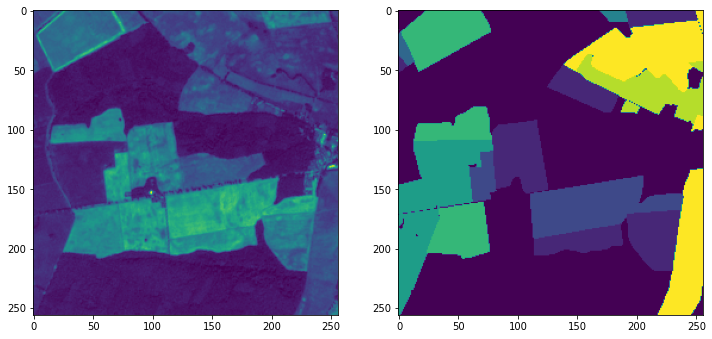

In [ ]:
import matplotlib.pyplot as plt

batch_sample = train_seq[0][0]

smp_idx = 0
img_sample = batch_sample[smp_idx]
mask_sample = train_seq[0][1][smp_idx]

print(len(train_seq))
print(img_sample.shape)
print(mask_sample.shape)


figure, axarr = plt.subplots(1, 2)
figure.set_size_inches((12,12))

axarr[0].imshow(img_sample[..., 0])
axarr[1].imshow(mask_sample)

plt.show()

# Model definition

In [ ]:
from keras.models import Model
from keras.layers import ( 
    BatchNormalization, Conv2D, Conv2DTranspose,
    MaxPooling2D, UpSampling2D, Input, Rescaling,
    concatenate
)
from tensorflow.compat.v1 import reset_default_graph

def bn_conv_relu(input, filters, bachnorm_momentum, **conv2d_args):
    x = BatchNormalization(momentum=bachnorm_momentum)(input)
    x = Conv2D(filters, **conv2d_args)(x)
    return x

def bn_upconv_relu(input, filters, bachnorm_momentum, **conv2d_trans_args):
    x = BatchNormalization(momentum=bachnorm_momentum)(input)
    x = Conv2DTranspose(filters, **conv2d_trans_args)(x)
    return x

def satellite_unet(
    input_shape,
    num_classes=1,
    output_activation='sigmoid',
    num_layers=4):

    inputs = Input(input_shape)   
    
    filters = 64
    upconv_filters = 96

    kernel_size = (3,3)
    activation = 'relu'
    strides = (1,1)
    padding = 'same'
    kernel_initializer = 'he_normal'

    conv2d_args = {
        'kernel_size':kernel_size,
        'activation':activation, 
        'strides':strides,
        'padding':padding,
        'kernel_initializer':kernel_initializer
        }

    conv2d_trans_args = {
        'kernel_size':kernel_size,
        'activation':activation, 
        'strides':(2,2),
        'padding':padding,
        'output_padding':(1,1)
        }

    bachnorm_momentum = 0.01

    pool_size = (2,2)
    pool_strides = (2,2)
    pool_padding = 'valid'

    maxpool2d_args = {
        'pool_size':pool_size,
        'strides':pool_strides,
        'padding':pool_padding,
        }
    
    x = Conv2D(filters, **conv2d_args)(inputs)
    c1 = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)    
    x = bn_conv_relu(c1, filters, bachnorm_momentum, **conv2d_args)
    x = MaxPooling2D(**maxpool2d_args)(x)

    down_layers = []

    for l in range(num_layers):
        x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
        x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
        down_layers.append(x)
        x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
        x = MaxPooling2D(**maxpool2d_args)(x)

    x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
    x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
    x = bn_upconv_relu(x, filters, bachnorm_momentum, **conv2d_trans_args)

    for conv in reversed(down_layers):        
        x = concatenate([x, conv])  
        x = bn_conv_relu(x, upconv_filters, bachnorm_momentum, **conv2d_args)
        x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
        x = bn_upconv_relu(x, filters, bachnorm_momentum, **conv2d_trans_args)

    x = concatenate([x, c1])
    x = bn_conv_relu(x, upconv_filters, bachnorm_momentum, **conv2d_args)
    x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
           
    outputs = Conv2D(num_classes, kernel_size=(1,1), strides=(1,1), activation=output_activation, padding='valid') (x)       
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model


In [ ]:
reset_default_graph()
input_shape=batch_sample.shape[1:]

print(input_shape)

model = satellite_unet(
    input_shape = img_sample.shape,
    num_classes = len(CLASSES)+1,
    output_activation = 'softmax',
)

model.summary()

(256, 256, 3)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                               

# Train

In [ ]:
model.load_weights("drive/MyDrive/germany_sentinel2_data/UNet_12.h5")

model.compile(
    optimizer='adam', 
    loss=keras.losses.SparseCategoricalCrossentropy(),
     metrics=[
        'sparse_categorical_accuracy',
    ]
)

callbacks = [
    keras.callbacks.ModelCheckpoint("drive/MyDrive/germany_sentinel2_data/UNet_12.h5", save_best_only=True, monitor='val_loss', mode='min')
]

training = model.fit(train_seq, validation_data=val_seq, epochs=8, callbacks=callbacks)


fig, axes = plt.subplots(1,2, figsize=(12, 6))

axes[0].plot(training.history['loss'])
axes[0].plot(training.history['val_loss'])
axes[0].set_title('Losses')
axes[0].legend([ 'Train loss',  'Validation loss'], loc='upper left')

axes[1].plot(training.history['sparse_categorical_accuracy'])
axes[1].plot(training.history['val_sparse_categorical_accuracy'])
axes[1].set_title('Sparse Categorical Accuracy')
axes[1].legend([ 'Train Sparse Categorical Accuracy',  'Validation Sparse Categorical Accuracy'], loc='upper left')

Epoch 1/20
235/235 [==============================] - 501s 2s/step - loss: 1.4173 - sparse_categorical_accuracy: 0.5238 - val_loss: 1.2970 - val_sparse_categorical_accuracy: 0.5503
Epoch 2/20
235/235 [==============================] - 461s 2s/step - loss: 1.2803 - sparse_categorical_accuracy: 0.5555 - val_loss: 1.2396 - val_sparse_categorical_accuracy: 0.5633
Epoch 3/20
235/235 [==============================] - 524s 2s/step - loss: 1.1909 - sparse_categorical_accuracy: 0.5868 - val_loss: 1.1329 - val_sparse_categorical_accuracy: 0.6088
Epoch 4/20
235/235 [==============================] - 711s 3s/step - loss: 0.9853 - sparse_categorical_accuracy: 0.6655 - val_loss: 0.8278 - val_sparse_categorical_accuracy: 0.7272
Epoch 5/20
235/235 [==============================] - 738s 3s/step - loss: 0.7274 - sparse_categorical_accuracy: 0.7647 - val_loss: 0.6163 - val_sparse_categorical_accuracy: 0.8065
Epoch 6/20
235/235 [==============================] - 732s 3s/step - loss: 0.5362 - sparse_cate

# Results

In [ ]:
from sklearn.metrics import classification_report

preds = np.array([])
test_labels = np.array([])
for i in range(len(val_seq) // 4):
    x_test, y_test = val_seq[i]
    prediction = model.predict(x_test)
    preds = np.append(preds, np.argmax(model.predict(x_test), axis=-1).flatten())
    test_labels = np.append(test_labels, y_test.flatten())

print(classification_report(test_labels, preds, target_names = ['Nothing']+CLASSES))